In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import os
import cv2
from PIL import Image
from scipy import ndimage
from PIL import Image, ImageChops
import skimage.measure as measure 
import imutils
from tqdm import tqdm
from skimage import color

In [2]:
'''Path to directories - nuclei stain images and raman images'''
nuclei_stain = './data/nuclei_stain/'
raman = './data/raman/'

In [3]:
'''Get segmentation files to perform segmentation from NucleiAIzer'''
nuclei_files = []
for _,_,files in os.walk(nuclei_stain):
    for file in files:
        nuclei_files.append(nuclei_stain+file)

### TODO: Include NucleAIzer from website

# Calibration

In [4]:
'''Calibration'''
cali_raman = cv2.imread('./data/Beads_control/Raman/10um_Bead_1.5W_1V_100steps_20msec.png')
cali_brightf = cv2.imread('./data/Beads_control/BF_10um_Bead_1.5W_1V_100steps_20msec/Default/img_channel000_position000_time000000000_z000.tif')

In [5]:
'''Shapes of bright field image and raman calibration image'''
cali_brightf.shape, cali_raman.shape

((2048, 2048, 3), (420, 560, 3))

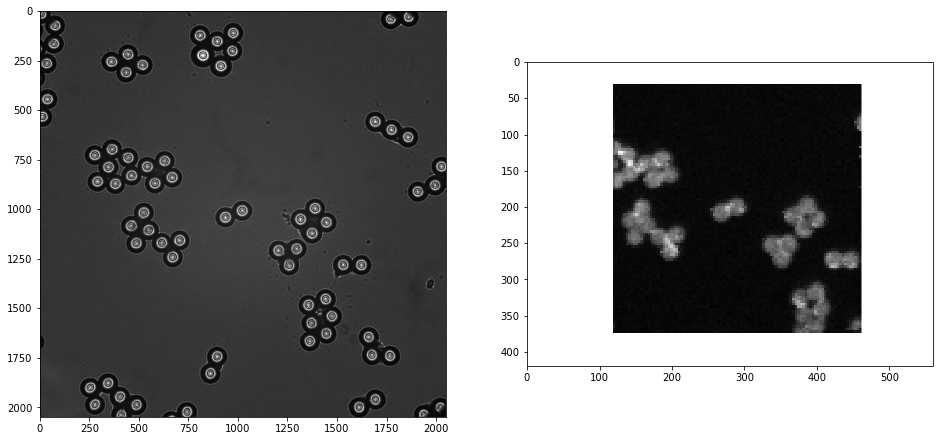

In [6]:
'''Plot bright field and raman calibration image'''
fig, axs = plt.subplots(ncols=2,figsize = (16,16))
axs[0].imshow(cali_brightf)
axs[1].imshow(cali_raman)
plt.tight_layout;

In [7]:
'''Function to trim borders of raman calibration image'''
def trim(im):
    bg = Image.new(im.mode, im.size, im.getpixel((0,0)))
    diff = ImageChops.difference(im, bg)
    diff = ImageChops.add(diff, diff, 2.0, -100)
    bbox = diff.getbbox()
    if bbox:
        return im.crop(bbox)
im = Image.fromarray(cali_raman)
im = trim(im)

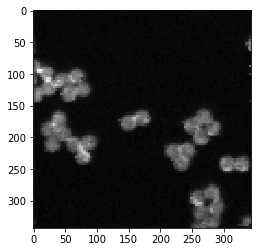

In [8]:
cali_raman_cropped = np.asarray(im)
plt.imshow(cali_raman_cropped);

In [9]:
'''Multiscale template matching'''
def match_temp(temp,img):
    t_dim = temp.shape[0]
    i_dim = img.shape[0]
    found = None
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.Canny(img, 15, 100)
    gray = cv2.cvtColor(temp, cv2.COLOR_BGR2GRAY)
    for dims in tqdm(range(t_dim,i_dim)):
        resized = imutils.resize(gray, width = dims, height = dims)
        edged = cv2.Canny(resized,50,200)
        match = cv2.matchTemplate(img,resized, cv2.TM_CCOEFF)
        (_, maxVal,_,maxLoc) = cv2.minMaxLoc(match)
        if found==None or maxVal>found[0]:
            found = (maxVal,maxLoc,dims)
    return found 

In [10]:
loc_dims = match_temp(cali_raman_cropped,cali_brightf)
(_,location,dimensions) = loc_dims

100%|██████████| 1705/1705 [02:31<00:00, 11.27it/s]


In [11]:
location,dimensions

((344, 330), 1359)

Template matching by eye: 1312x1312 view field for 2048x2048. 
Template macthing : 1372x1372 view field for 2048x2048

In [12]:
'''By eye'''
temp_loc = (368,355)
temp_dims = 1312

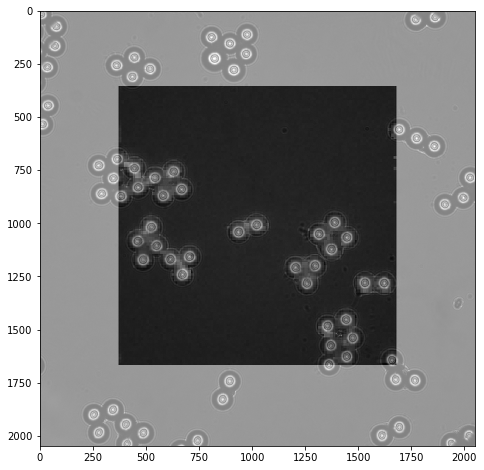

In [13]:
'''Check calibration: if raman view field matches the corresponding tiff image'''
resized_cali_raman = Image.fromarray(cali_raman_cropped).resize((temp_dims,temp_dims),Image.ANTIALIAS)
final = Image.new('RGB', (cali_brightf.shape[0],cali_brightf.shape[1]),(255,255,255))
final.paste(resized_cali_raman, (temp_loc[0],temp_loc[1]))
final_arr = np.array(final)
plt.figure(figsize = (8,8))
plt.imshow(cali_brightf)
plt.imshow(final_arr, alpha=0.5);

# Crop raman view in segmented masks

In [14]:
'''Get segmented files'''
labelled_images = './data/labelled/'
labelled_files = []
mask_names = []
for _,_,files in os.walk(labelled_images):
    for file in files:
        mask_names.append("_".join(file.split("_", 2)[:2]))
        labelled_files.append(labelled_images+file)

In [15]:
'''Read mask images'''
masks = []
for labelled_file in labelled_files:
    mask = plt.imread(labelled_file)
    masks.append(mask)

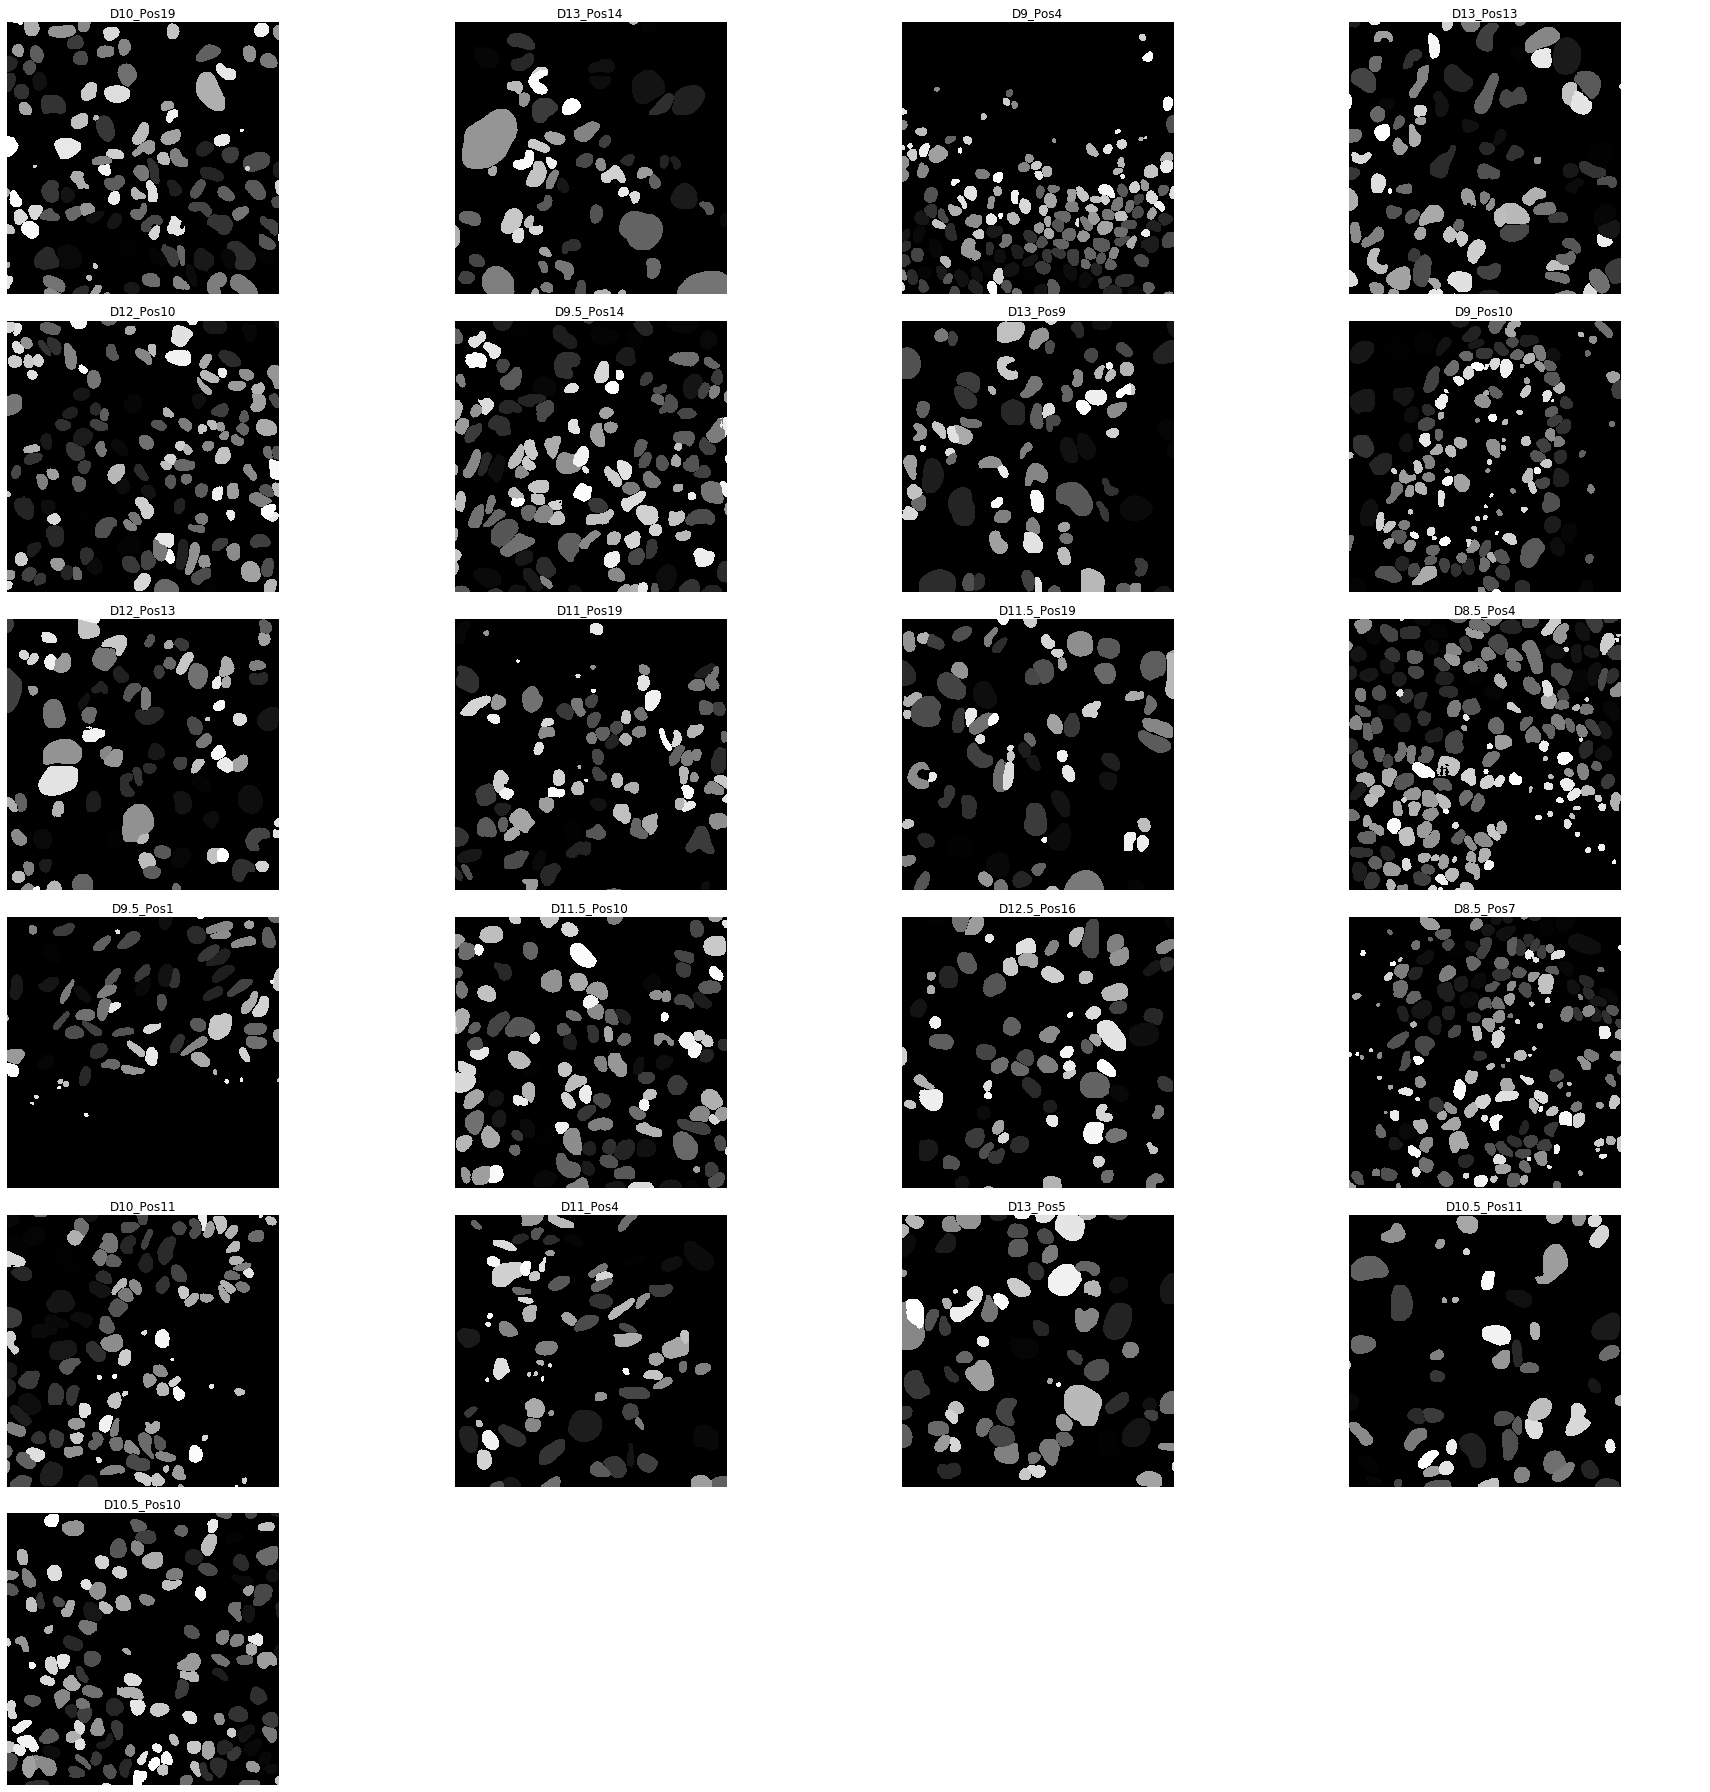

In [16]:
'''Plot mask images'''
fig, ax = plt.subplots(6,4, figsize=(25,25))
for i, (a,name,img) in enumerate(zip(ax.flat,mask_names,masks)):
    a.imshow(img, cmap='gray')
    a.set_title(name)
    [a.axis('off') for a in ax.flat]
plt.tight_layout()

In [17]:
'''Crop raman view field from the masks'''
cropped_masks = []
for mask in masks:
    cropped_masks.append(mask[temp_loc[0]:temp_loc[0]+temp_dims,temp_loc[1]:temp_loc[1]+temp_dims])

In [18]:
len(np.unique(cropped_masks[0]+1)),np.shape(cropped_masks[0])

(52, (1312, 1312))

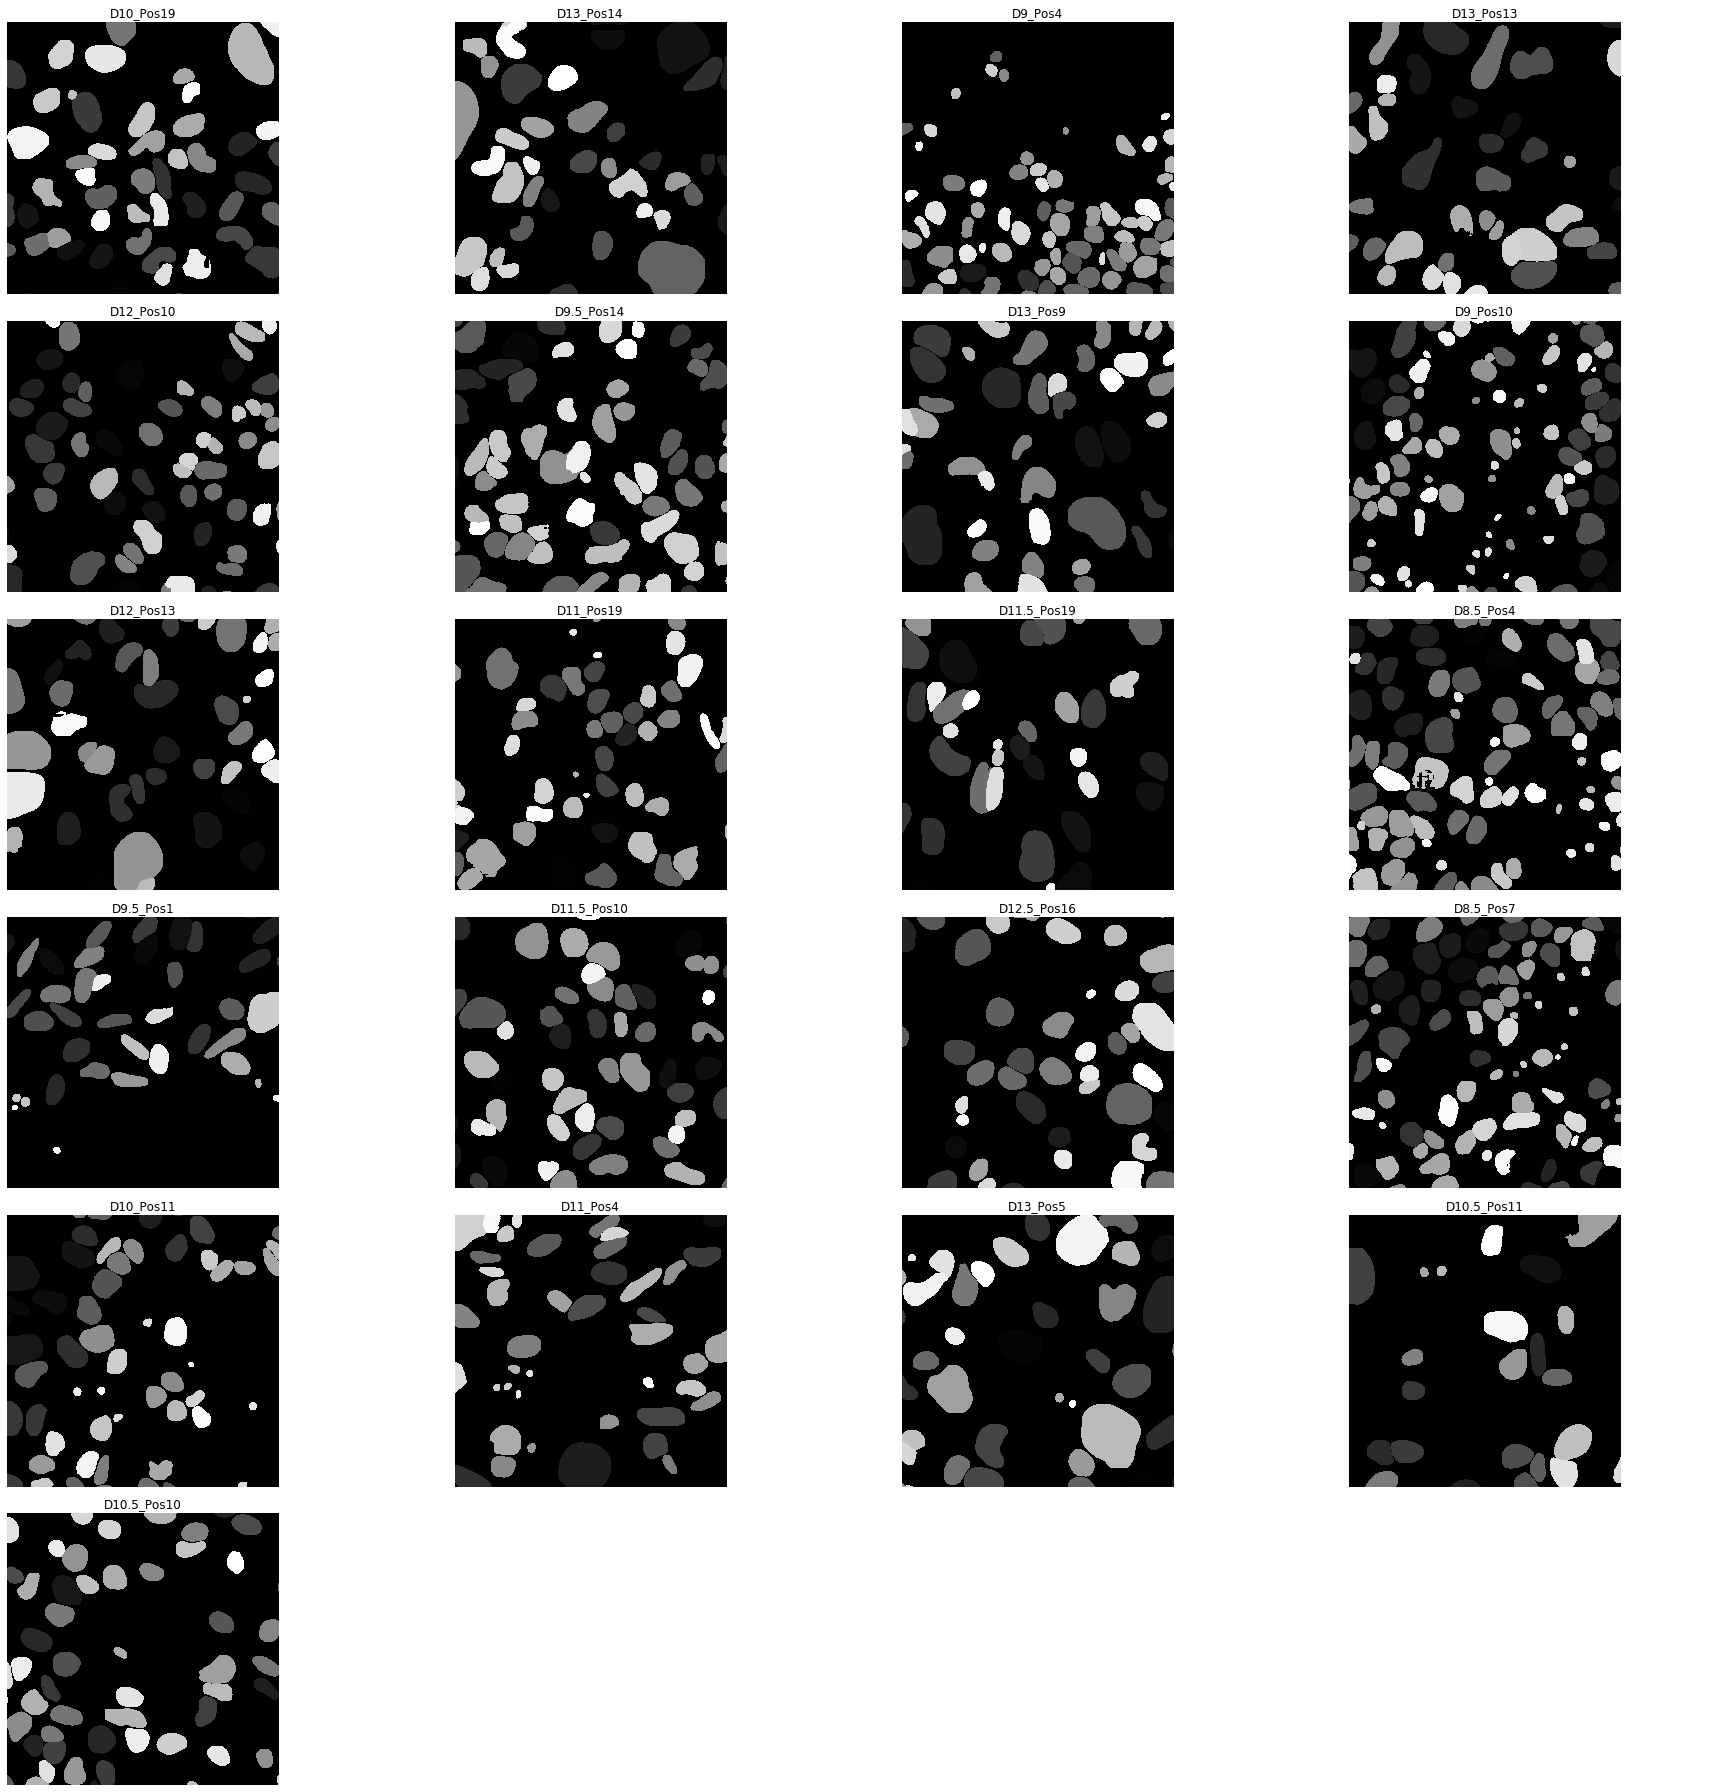

In [19]:
'''Plot cropped mask images'''
fig, ax = plt.subplots(6,4, figsize=(25,25))
for i, (a,name,img) in enumerate(zip(ax.flat,mask_names,cropped_masks)):
    a.imshow(img, cmap='gray')
    a.set_title(name)
    [a.axis('off') for a in ax.flat]
plt.tight_layout()

In [20]:
''' Function to downsample masks to shape 100x100'''
def downsample(im):
    factor = 13.12
    small = cv2.resize(im, (int(im.shape[1]//factor), 
                             int(im.shape[0]//factor)),
                            interpolation=cv2.INTER_NEAREST)
    small = (np.array(small)).astype('int')
    return small

In [21]:
'''Downsample masks '''
small_masks = []
for cm in cropped_masks:
    small_masks.append(downsample(cm))

In [22]:
len(np.unique(small_masks[0]+1)),np.shape(small_masks[0])

(49, (100, 100))

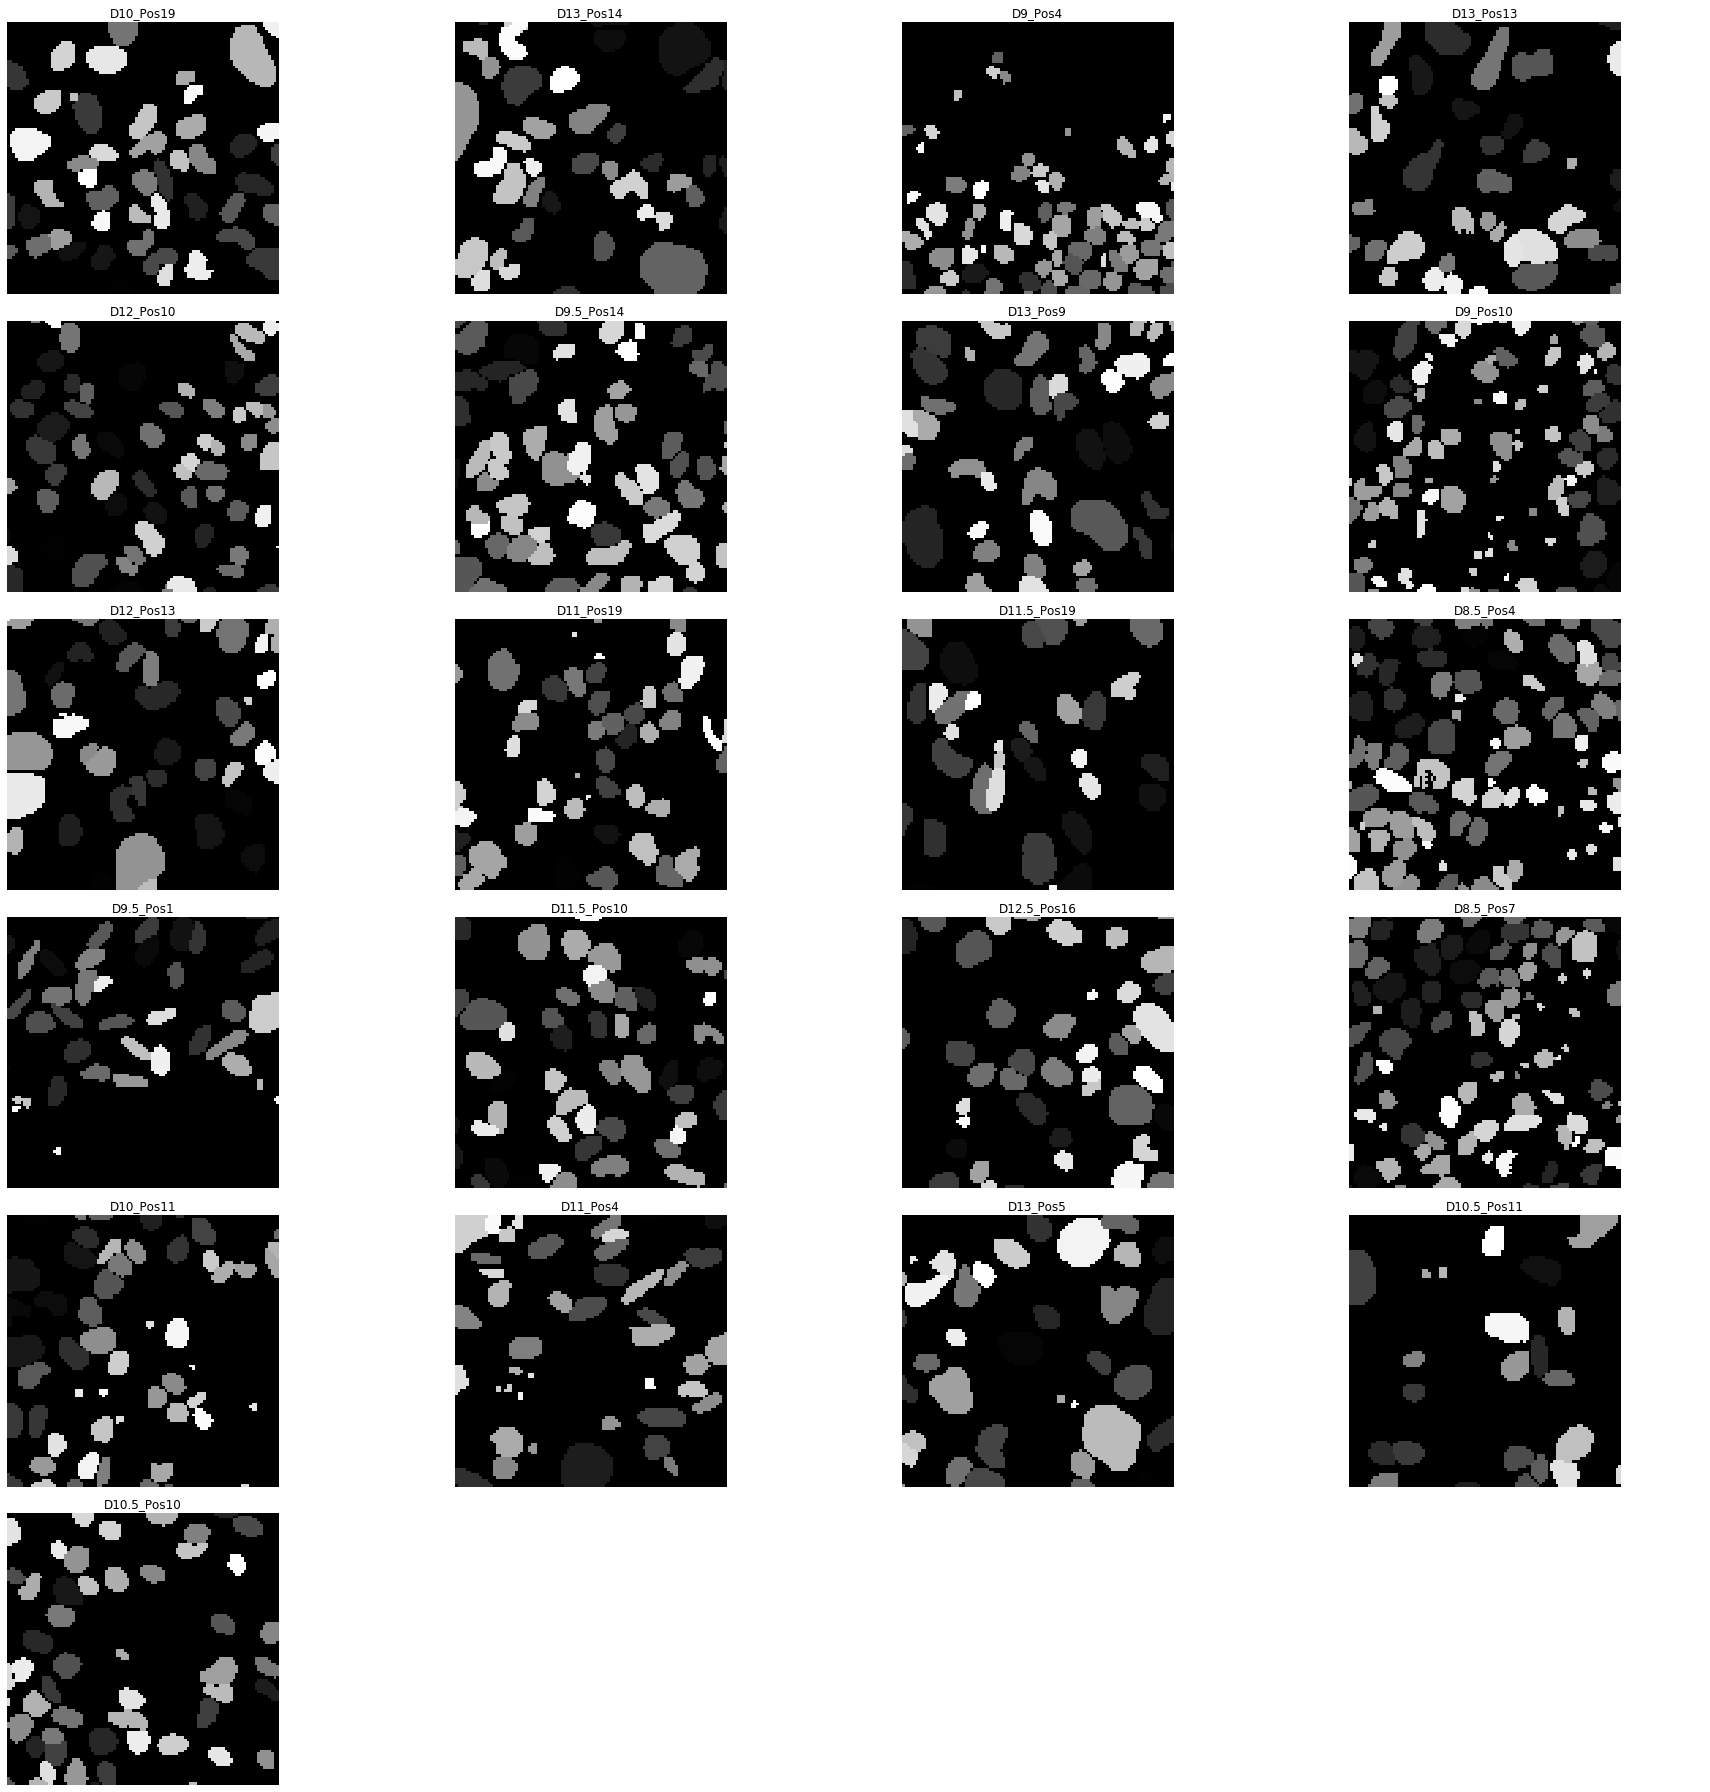

In [23]:
'''Plot down-sampled cropped mask images'''
fig, ax = plt.subplots(6,4, figsize=(25,25))
for i, (a,name,img) in enumerate(zip(ax.flat,mask_names,small_masks)):
    a.imshow(img, cmap='gray')
    a.set_title(name)
    [a.axis('off') for a in ax.flat]
plt.tight_layout()

## Remove small objects and eccentricities without losing labels 

In [24]:
'''Find eccentricities and areas of each cell and remove the very small and eccentric cells'''
areas = []
ecc = []
for sm in small_masks:
    props = measure.regionprops(sm)
    for prop in props:
        areas.append(prop.area)
        ecc.append(prop.eccentricity)

In [ ]:
'''plot areas of cells'''
unique_ele, counts = np.unique(areas, return_counts = True)
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(unique_ele,counts)
#plt.show()

In [ ]:
'''Find labels of small cells in each image'''
labels = []
for sm in small_masks:
    props = measure.regionprops(sm) 
    label_cell = []
    for prop in props:
        if prop.area < 11:
            label_cell.append(prop.label)
    labels.append(label_cell)


# Find raman spectra for each cell

In [25]:
'''Get calibration raman dat file and plot 669 peak'''
cali_raman_dat = np.genfromtxt('./data/Beads_control/Raman/10um_Bead_1.5W_1V_100steps_20msec.dat', delimiter=',', dtype=None)

In [26]:
cali_raman_dat.shape

(10000, 1340)

In [27]:
cali_raman_dat_reshaped = np.reshape(cali_raman_dat[:,668],(100,100))

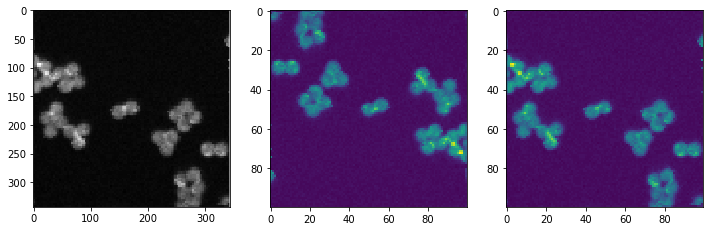

In [28]:
fig,ax = plt.subplots(1,3,figsize = (12,12))
ax[0].imshow(cali_raman_cropped)
ax[1].imshow(cali_raman_dat_reshaped)
ax[2].imshow(np.rot90(cali_raman_dat_reshaped,2,(0,1)));

Rotate raman data files by 180 after extraction. 

In [29]:
raman_dat_im = np.rot90(cali_raman_dat_reshaped,2,(0,1))

In [32]:
''' Function to upsample masks to shape 100x100'''
def upsample(im,factor):
    big = cv2.resize(im, (int(im.shape[1]*factor), 
                             int(im.shape[0]*factor)),
                            interpolation=cv2.INTER_NEAREST)
    big = (np.array(big)).astype('int')
    return big

In [34]:
WHITE = [255,255,255]
factor = 13.12
raman_upsamp = upsample(raman_dat_im,factor)
raman_upsamp = cv2.copyMakeBorder(raman_upsamp, 368, 368, 368, 368, cv2.BORDER_CONSTANT,value=WHITE)

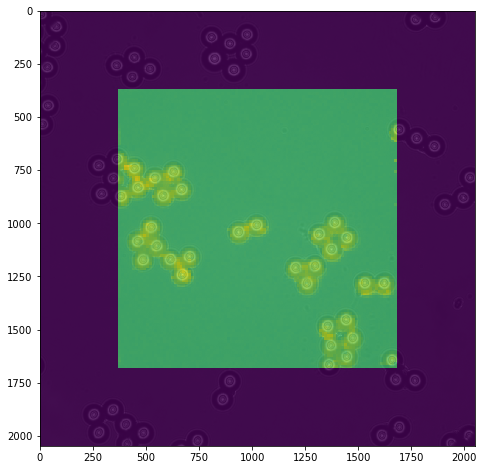

In [35]:
'''raman 669 2D mapping over brightfield image'''
plt.figure(figsize = (8,8))
plt.imshow(cali_brightf)
plt.imshow(raman_upsamp,alpha=0.8);

In [37]:
'''Extract Raman Spectra from dat files
TODO(Done): rotate by 90 two times along x and y(0,1)'''
raman_specs = []
for file in tqdm(mask_names):
    ramans = np.reshape(np.genfromtxt(raman+file+'.dat', delimiter=',', dtype=None),(100,100,1340))
    raman_specs.append(np.rot90(ramans,2,(0,1)))

100%|██████████| 21/21 [10:18<00:00, 29.47s/it]


In [38]:
np.shape(small_masks), np.shape(raman_specs)

((21, 100, 100), (21, 100, 100, 1340))

In [39]:
'''Mapping each pixel in each cell to raman spectra'''
label_pos = []
for sm in small_masks:
    labels = np.unique(sm)
    labels = labels[labels!=0]
    label_pos.append([np.transpose(np.where(sm == label)) for label in labels])      

In [40]:
'''Create a dict - image,cell-id,spectra-id,pixelpos'''
cell_ram = {'image','cell','spectra','pixel','spectra-id'}
cell_ram = dict([(key, []) for key in cell_ram])
for pos,ram,name in zip(label_pos,raman_specs,mask_names):
    for coords,cc in zip(pos,range(len(pos))):
        for coord,sc in zip(coords,range(len(coords))):
            cell_ram['image'].append(name)
            cell_ram['cell'].append('cell'+'_'+str(cc+1))
            cell_ram['spectra'].append(ram[coord[0],coord[1]])
            cell_ram['pixel'].append(coord)
            cell_ram['spectra-id'].append(str(sc+1))

In [41]:
'''Create a dataframe'''
import pandas as pd
spatial = pd.DataFrame.from_dict(cell_ram)

In [42]:
spatial = spatial[['image','cell','spectra-id','pixel','spectra']]

In [43]:
spatial

,image,cell,spectra-id,pixel,spectra
0,D10_Pos19,cell_1,1,"[94, 40]","[588, 587, 586, 585, 589, 586, 585, 589, 588, ..."
1,D10_Pos19,cell_1,2,"[94, 41]","[588, 587, 588, 584, 590, 588, 588, 588, 589, ..."
2,D10_Pos19,cell_1,3,"[94, 42]","[588, 586, 585, 588, 587, 587, 587, 586, 587, ..."
3,D10_Pos19,cell_1,4,"[95, 39]","[588, 586, 588, 587, 586, 585, 587, 587, 586, ..."
4,D10_Pos19,cell_1,5,"[95, 40]","[588, 586, 588, 587, 586, 585, 587, 587, 586, ..."
...,...,...,...,...,...
58134,D10.5_Pos10,cell_52,36,"[21, 84]","[589, 587, 587, 587, 587, 587, 584, 586, 586, ..."
58135,D10.5_Pos10,cell_52,37,"[21, 85]","[587, 589, 587, 587, 586, 585, 588, 587, 586, ..."
58136,D10.5_Pos10,cell_52,38,"[21, 86]","[589, 587, 586, 585, 586, 585, 587, 587, 586, ..."
58137,D10.5_Pos10,cell_52,39,"[22, 84]","[586, 587, 588, 590, 586, 587, 584, 588, 586, ..."


In [44]:
non_spatial = pd.DataFrame(columns=['image', 'cell', 'mean_spectra'])
for name in mask_names:
    temp = spatial.loc[spatial['image']==name]
    unique_cells = temp.cell.unique()
    for cell in unique_cells:
        t = temp.loc[temp['cell']==cell]
        s = np.array(t['spectra'].tolist())
        mean_spectra = s.mean(axis=0)
        non_spatial = non_spatial.append({'image':name, 'cell':cell, 'mean_spectra':mean_spectra}, ignore_index=True)

In [45]:
non_spatial

,image,cell,mean_spectra
0,D10_Pos19,cell_1,"[588.45, 587.1, 587.1, 586.825, 587.325, 586.8..."
1,D10_Pos19,cell_2,"[588.86, 587.48, 586.96, 587.18, 586.82, 586.8..."
2,D10_Pos19,cell_3,"[588.5964912280701, 587.6315789473684, 587.280..."
3,D10_Pos19,cell_4,"[588.3, 587.5, 587.2833333333333, 587.13333333..."
4,D10_Pos19,cell_5,"[588.4262295081967, 587.1311475409836, 587.049..."
...,...,...,...
1106,D10.5_Pos10,cell_48,"[588.25, 587.1666666666666, 586.6666666666666,..."
1107,D10.5_Pos10,cell_49,"[588.28125, 587.375, 586.71875, 587.125, 587.0..."
1108,D10.5_Pos10,cell_50,"[588.3518518518518, 586.8518518518518, 586.537..."
1109,D10.5_Pos10,cell_51,"[588.65625, 587.1875, 586.453125, 586.828125, ..."


In [46]:
column_names=[]
column_names_mean=[]
for i in range(1340):
    column_names.append('spectra_'+str(i))
    column_names_mean.append('mean_spectra_'+str(i))

In [47]:
spatial_temp = pd.DataFrame(spatial.spectra.to_list(), columns = column_names)
spatial = pd.concat([spatial[['image','cell','spectra-id','pixel']],spatial_temp],axis=1,sort=False)
spatial

,image,cell,spectra-id,pixel,spectra_0,spectra_1,spectra_2,spectra_3,spectra_4,spectra_5,...,spectra_1330,spectra_1331,spectra_1332,spectra_1333,spectra_1334,spectra_1335,spectra_1336,spectra_1337,spectra_1338,spectra_1339
0,D10_Pos19,cell_1,1,"[94, 40]",588,587,586,585,589,586,...,585,586,587,588,587,588,587,589,588,586
1,D10_Pos19,cell_1,2,"[94, 41]",588,587,588,584,590,588,...,588,589,588,587,586,587,586,588,590,588
2,D10_Pos19,cell_1,3,"[94, 42]",588,586,585,588,587,587,...,588,586,587,587,585,587,589,588,589,586
3,D10_Pos19,cell_1,4,"[95, 39]",588,586,588,587,586,585,...,586,586,586,586,588,588,588,587,589,584
4,D10_Pos19,cell_1,5,"[95, 40]",588,586,588,587,586,585,...,586,586,586,586,588,588,588,587,589,584
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58134,D10.5_Pos10,cell_52,36,"[21, 84]",589,587,587,587,587,587,...,588,586,588,587,589,587,589,590,582,587
58135,D10.5_Pos10,cell_52,37,"[21, 85]",587,589,587,587,586,585,...,589,590,587,586,588,590,586,587,588,591
58136,D10.5_Pos10,cell_52,38,"[21, 86]",589,587,586,585,586,585,...,586,585,586,588,587,586,589,590,590,585
58137,D10.5_Pos10,cell_52,39,"[22, 84]",586,587,588,590,586,587,...,587,590,590,587,588,590,588,588,589,589


In [48]:
non_spatial_temp = pd.DataFrame(non_spatial.mean_spectra.to_list(), columns = column_names_mean)
non_spatial = pd.concat([non_spatial[['image','cell']],non_spatial_temp],axis=1,sort=False)
non_spatial

,image,cell,mean_spectra_0,mean_spectra_1,mean_spectra_2,mean_spectra_3,mean_spectra_4,mean_spectra_5,mean_spectra_6,mean_spectra_7,...,mean_spectra_1330,mean_spectra_1331,mean_spectra_1332,mean_spectra_1333,mean_spectra_1334,mean_spectra_1335,mean_spectra_1336,mean_spectra_1337,mean_spectra_1338,mean_spectra_1339
0,D10_Pos19,cell_1,588.450000,587.100000,587.100000,586.825000,587.325000,586.800000,586.775000,586.650000,...,587.475000,586.750000,587.350000,587.400000,587.075000,587.300000,587.625000,587.600000,587.400000,587.550000
1,D10_Pos19,cell_2,588.860000,587.480000,586.960000,587.180000,586.820000,586.820000,586.680000,586.860000,...,586.820000,586.920000,587.000000,586.900000,587.200000,587.060000,587.020000,587.120000,587.340000,587.040000
2,D10_Pos19,cell_3,588.596491,587.631579,587.280702,587.210526,586.929825,587.087719,586.491228,586.754386,...,586.877193,587.368421,587.140351,587.192982,587.192982,587.105263,587.473684,587.105263,587.561404,587.561404
3,D10_Pos19,cell_4,588.300000,587.500000,587.283333,587.133333,586.916667,586.733333,586.433333,586.800000,...,586.666667,586.966667,586.700000,586.766667,587.033333,587.116667,587.216667,587.250000,587.150000,587.333333
4,D10_Pos19,cell_5,588.426230,587.131148,587.049180,587.196721,587.032787,586.852459,586.721311,586.491803,...,586.950820,586.934426,586.918033,587.262295,587.327869,587.196721,587.131148,587.114754,587.540984,587.409836
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1106,D10.5_Pos10,cell_48,588.250000,587.166667,586.666667,586.750000,586.541667,586.708333,586.437500,586.187500,...,587.166667,587.000000,586.958333,587.270833,587.875000,587.375000,587.520833,588.062500,587.416667,587.583333
1107,D10.5_Pos10,cell_49,588.281250,587.375000,586.718750,587.125000,587.031250,586.656250,586.062500,586.281250,...,587.656250,587.031250,587.406250,587.375000,587.218750,588.281250,588.187500,587.125000,587.875000,587.406250
1108,D10.5_Pos10,cell_50,588.351852,586.851852,586.537037,586.537037,587.296296,586.481481,586.296296,586.222222,...,587.185185,587.018519,587.185185,587.388889,587.222222,587.037037,587.425926,587.203704,587.129630,587.500000
1109,D10.5_Pos10,cell_51,588.656250,587.187500,586.453125,586.828125,587.078125,586.359375,586.468750,586.546875,...,589.031250,588.656250,589.031250,588.718750,588.937500,589.390625,589.109375,588.859375,589.296875,589.312500


In [ ]:
'DONT RUN AGAIN'
spatial.to_csv('spatial.csv',index=False)
non_spatial.to_csv('non_spatial.csv',index=False)

### Control Images 
1. Visualization of raman spectra-pix pos mapping - to check if the mapping from spectra to image is right 
2. Visualization of spectra corresponding to nuclei only 
3. Visualization of spectra corresponding to nuclei and cytoplasm 

## 1. Check the accuracy of mapping between mask images and raman spectra

In [49]:
control_df = spatial[['image','cell','pixel','spectra_668']]

In [50]:
'''Create mask images'''
maskImages = []
for image in tqdm(mask_names):
    white = np.full((100,100,3),255)
    temp = control_df.loc[control_df['image'] == image]
    index = temp.groupby(['cell'],sort=False)['spectra_668'].idxmax().tolist()
    for rows in temp.itertuples():
        idx = rows[0]
        pix_pos = rows[3]
        if(idx in index):
            white[pix_pos[0],pix_pos[1]]=(255,0,0)
        else:
            white[pix_pos[0],pix_pos[1]]=(0,255,255)
    maskImages.append(white)    

100%|██████████| 21/21 [00:00<00:00, 52.36it/s]


In [51]:
'''upsample masks to 1312x1312'''
big_masks = []
factor = 13.12
for mi in maskImages:
    big_masks.append(upsample(mi,factor))

In [52]:
'''Generate created masks(1312x1312) overlayed on actual-masks(2048x2048)'''
pasted_masks=[]
for bm in tqdm(big_masks):
    c_mask = Image.fromarray(np.uint8(bm))
    white_img = Image.new('RGB',(2048,2048),(255,255,255))
    white_img.paste(c_mask,(temp_loc[0],temp_loc[1]))
    white_img = np.array(white_img)
    pasted_masks.append(white_img)

100%|██████████| 21/21 [00:00<00:00, 25.86it/s]


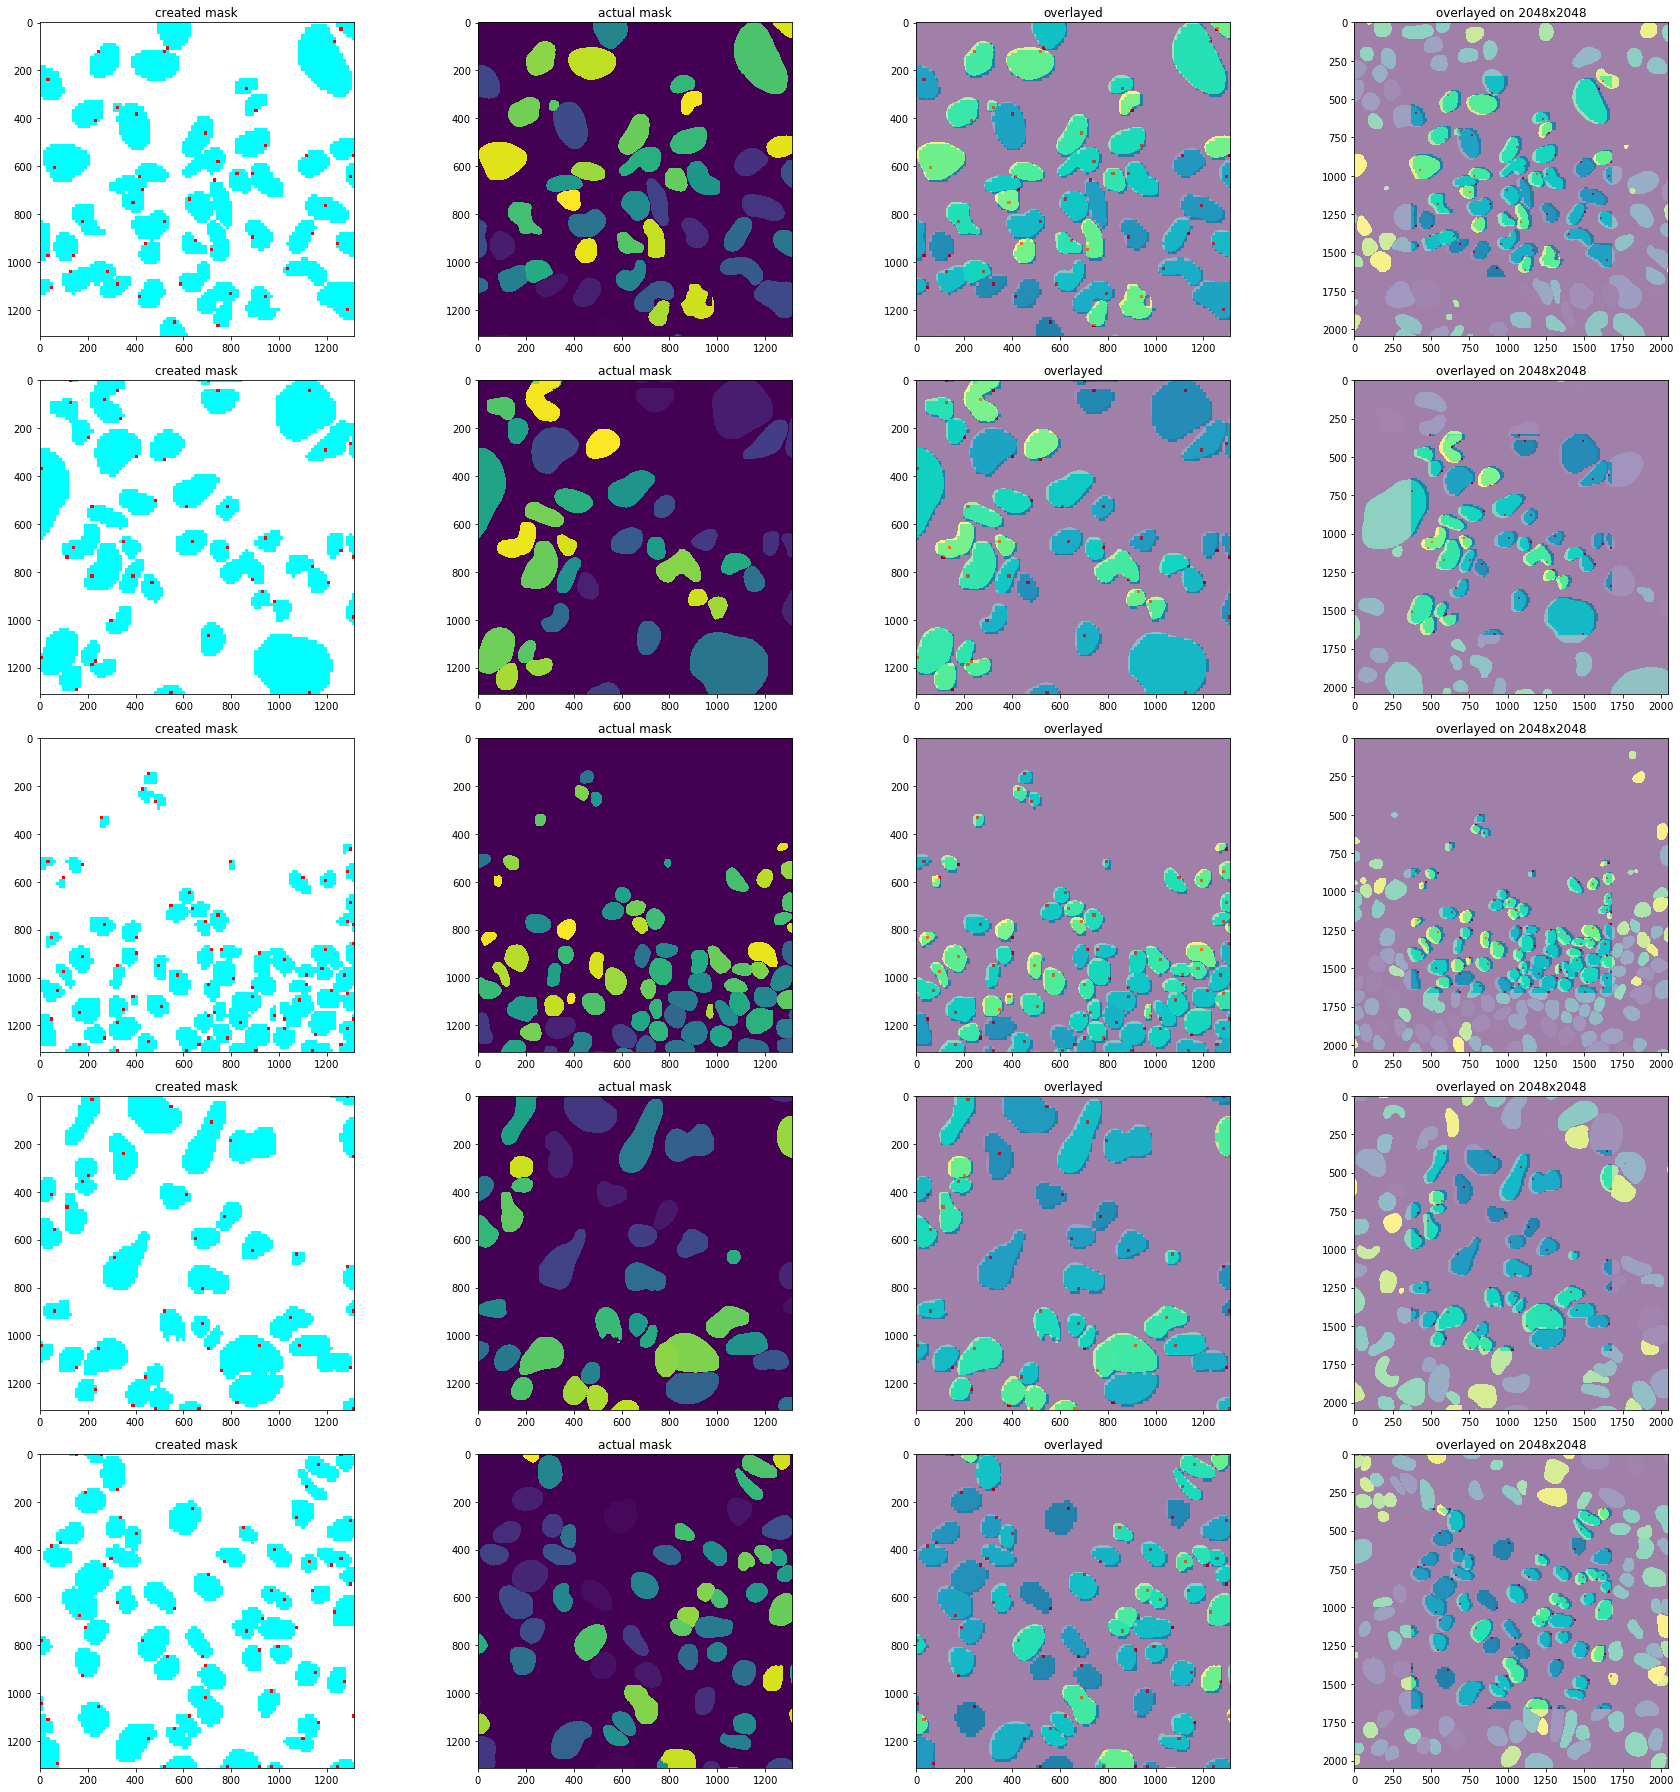

In [53]:
'''Plot upsampled mask, segmented image, created mask overlayed on cropped segmented mask and '''
fig, axs = plt.subplots(5,4, figsize=(25,25))
for i in range(5):
    axs[i][0].imshow(big_masks[i])
    axs[i][0].set_title('created mask')
    axs[i][1].imshow(cropped_masks[i])
    axs[i][1].set_title('actual mask')
    axs[i][2].imshow(cropped_masks[i])
    axs[i][2].imshow(big_masks[i],alpha=0.5)
    axs[i][2].set_title('overlayed')
    axs[i][3].imshow(masks[i])
    axs[i][3].imshow(pasted_masks[i],alpha=0.5)
    axs[i][3].set_title('overlayed on 2048x2048')
plt.tight_layout();

In [55]:
'''Create raman-mask(669) images from spatial data'''
ramanImages = []
for image in tqdm(mask_names):
    white = np.full((100,100),0)
    temp = control_df.loc[control_df['image'] == image]
    spec_obj = temp.groupby(['cell'],sort=False)['spectra_668']
    temp_list = []
    for specs in spec_obj:
        specs = specs[1].to_list()
        temp_list.append(specs)
    spec_vals = [t for temp in temp_list for t in temp]
    for rows,spec in zip(temp.itertuples(),spec_vals):
        pix_pos = rows[3]
        white[pix_pos[0],pix_pos[1]]= spec
    ramanImages.append(white)

100%|██████████| 21/21 [00:00<00:00, 76.93it/s]


## Visualization of Nuclei from 669 peak 

In [56]:
'''visualization of nuclei from 669 peak'''
ramanImagesRGB = []
for r_im in ramanImages:
    r_temp = color.label2rgb(r_im)
    ramanImagesRGB.append(r_temp)

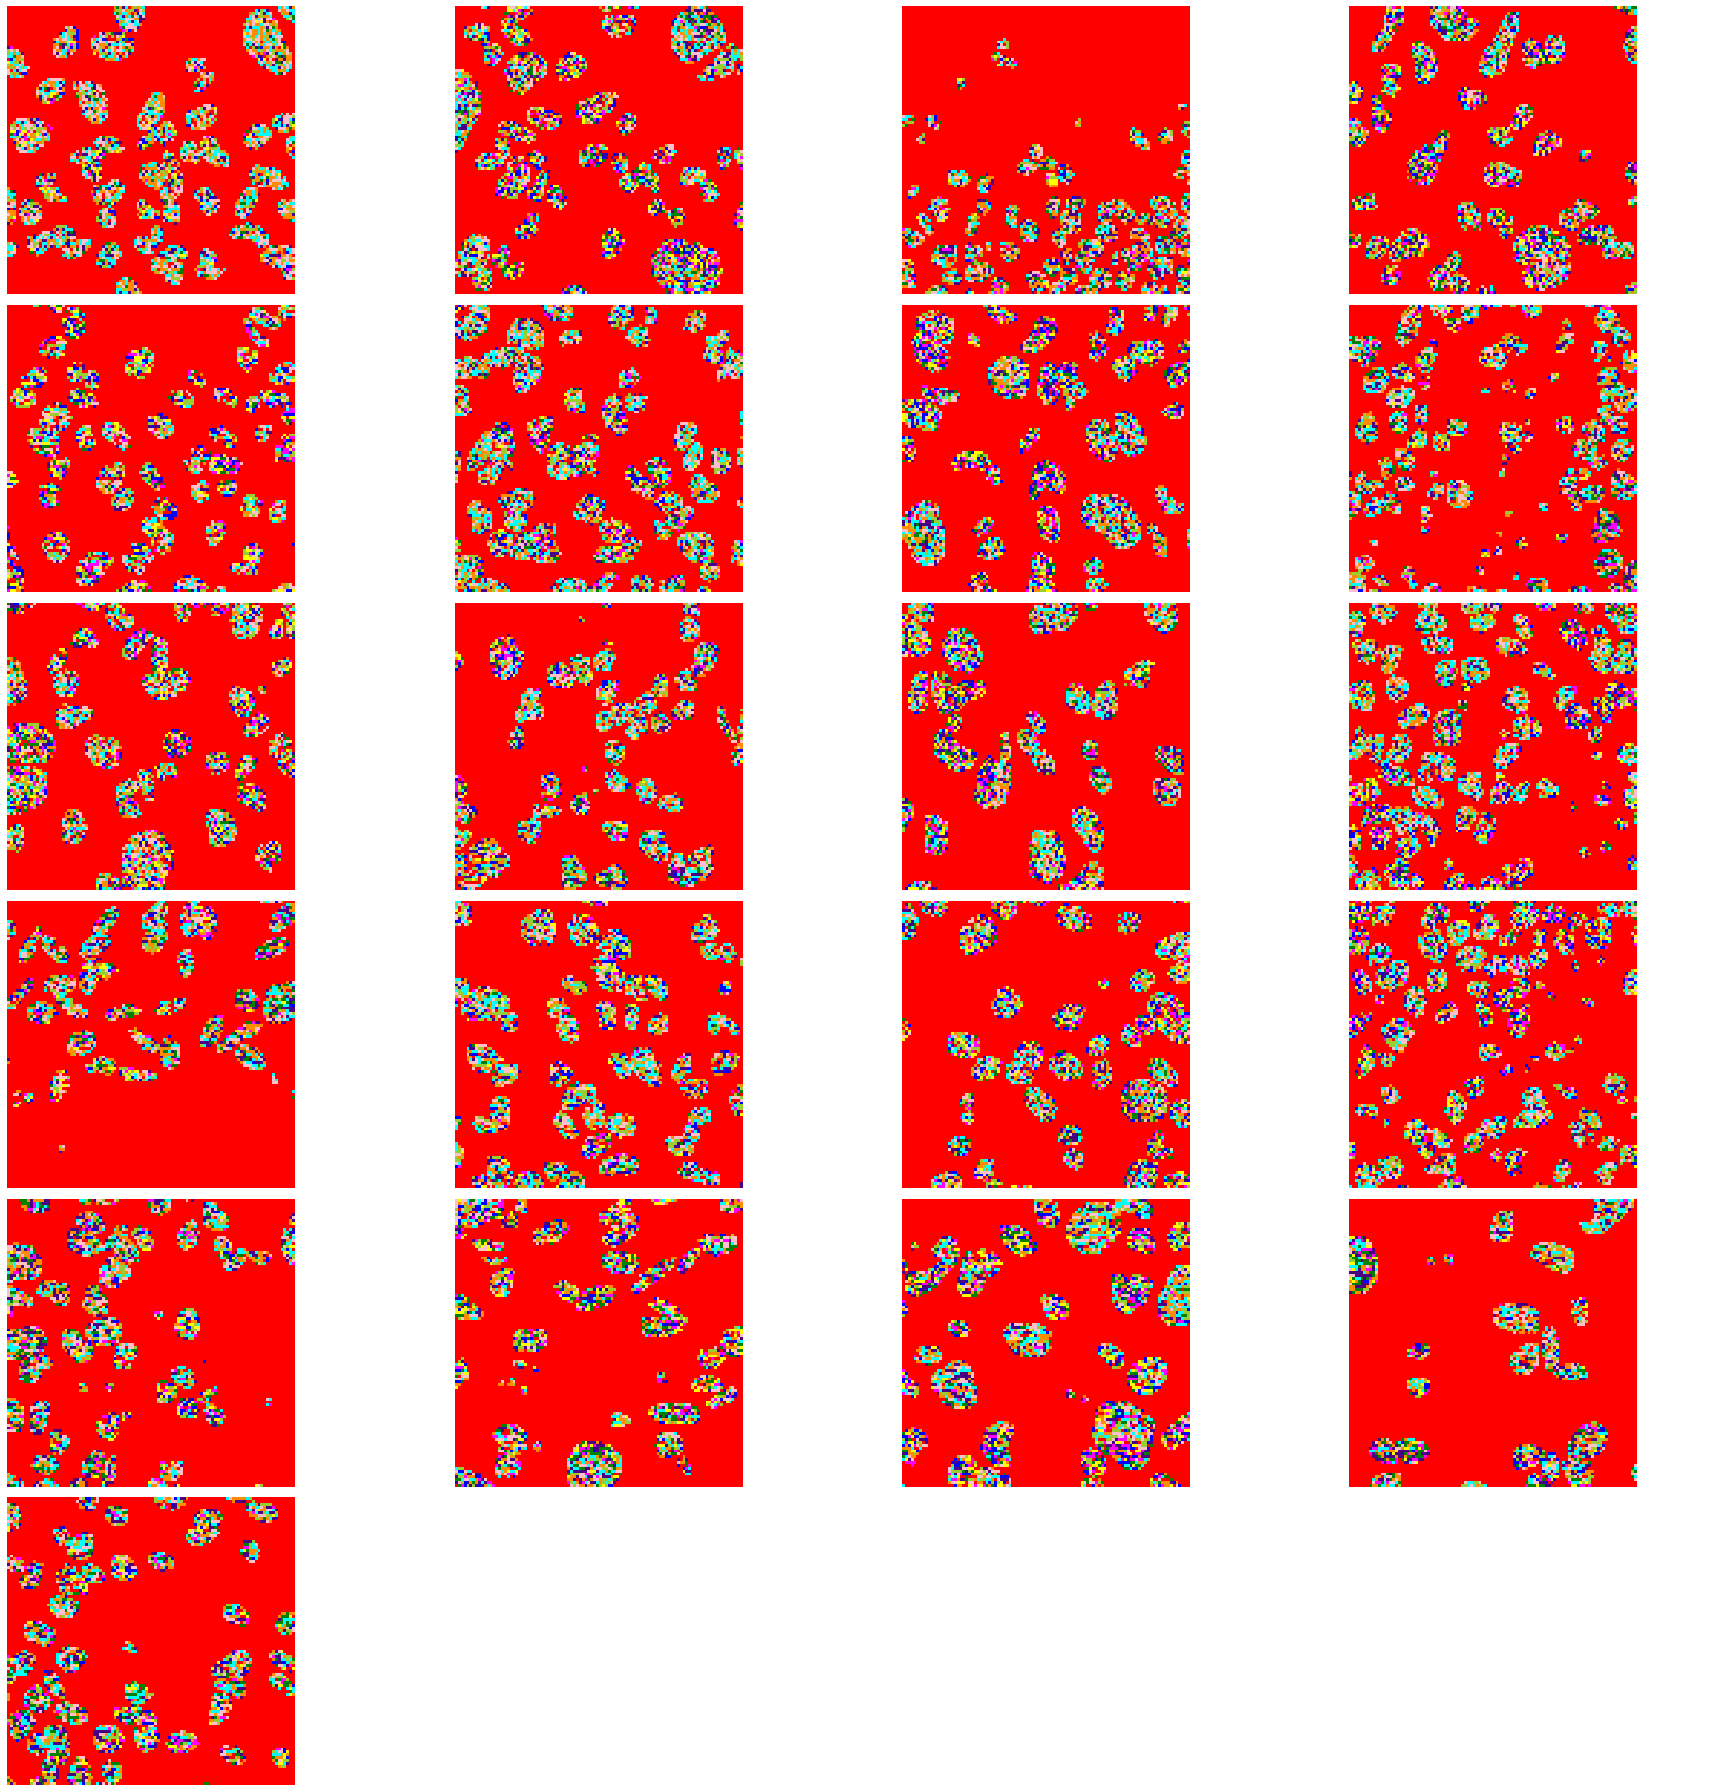

In [57]:
fig, ax = plt.subplots(6,4, figsize=(25,25))
for i, (a,img) in enumerate(zip(ax.flat,ramanImagesRGB)):
    a.imshow(img,cmap = 'coolwarm')
    [a.axis('off') for a in ax.flat]
plt.tight_layout();

## Visualization of raman 669 peak raw 

In [58]:
raman_669 = []
for file in tqdm(mask_names):
    ramans_raw = np.genfromtxt(raman+file+'.dat', delimiter=',', dtype=None)
    ramans_raw_669 = np.reshape(ramans_raw[:,668],(100,100))
    raman_669.append(ramans_raw_669)

100%|██████████| 21/21 [10:18<00:00, 29.44s/it]


In [59]:
raman_669_rot=[]
for ram in raman_669:
    rtemp = np.rot90(ram,2,(0,1))
    raman_669_rot.append(rtemp)

In [60]:
r_669_masks = []
factor = 13.12
for mi in raman_669_rot:
    r_669_masks.append(upsample(mi,factor))

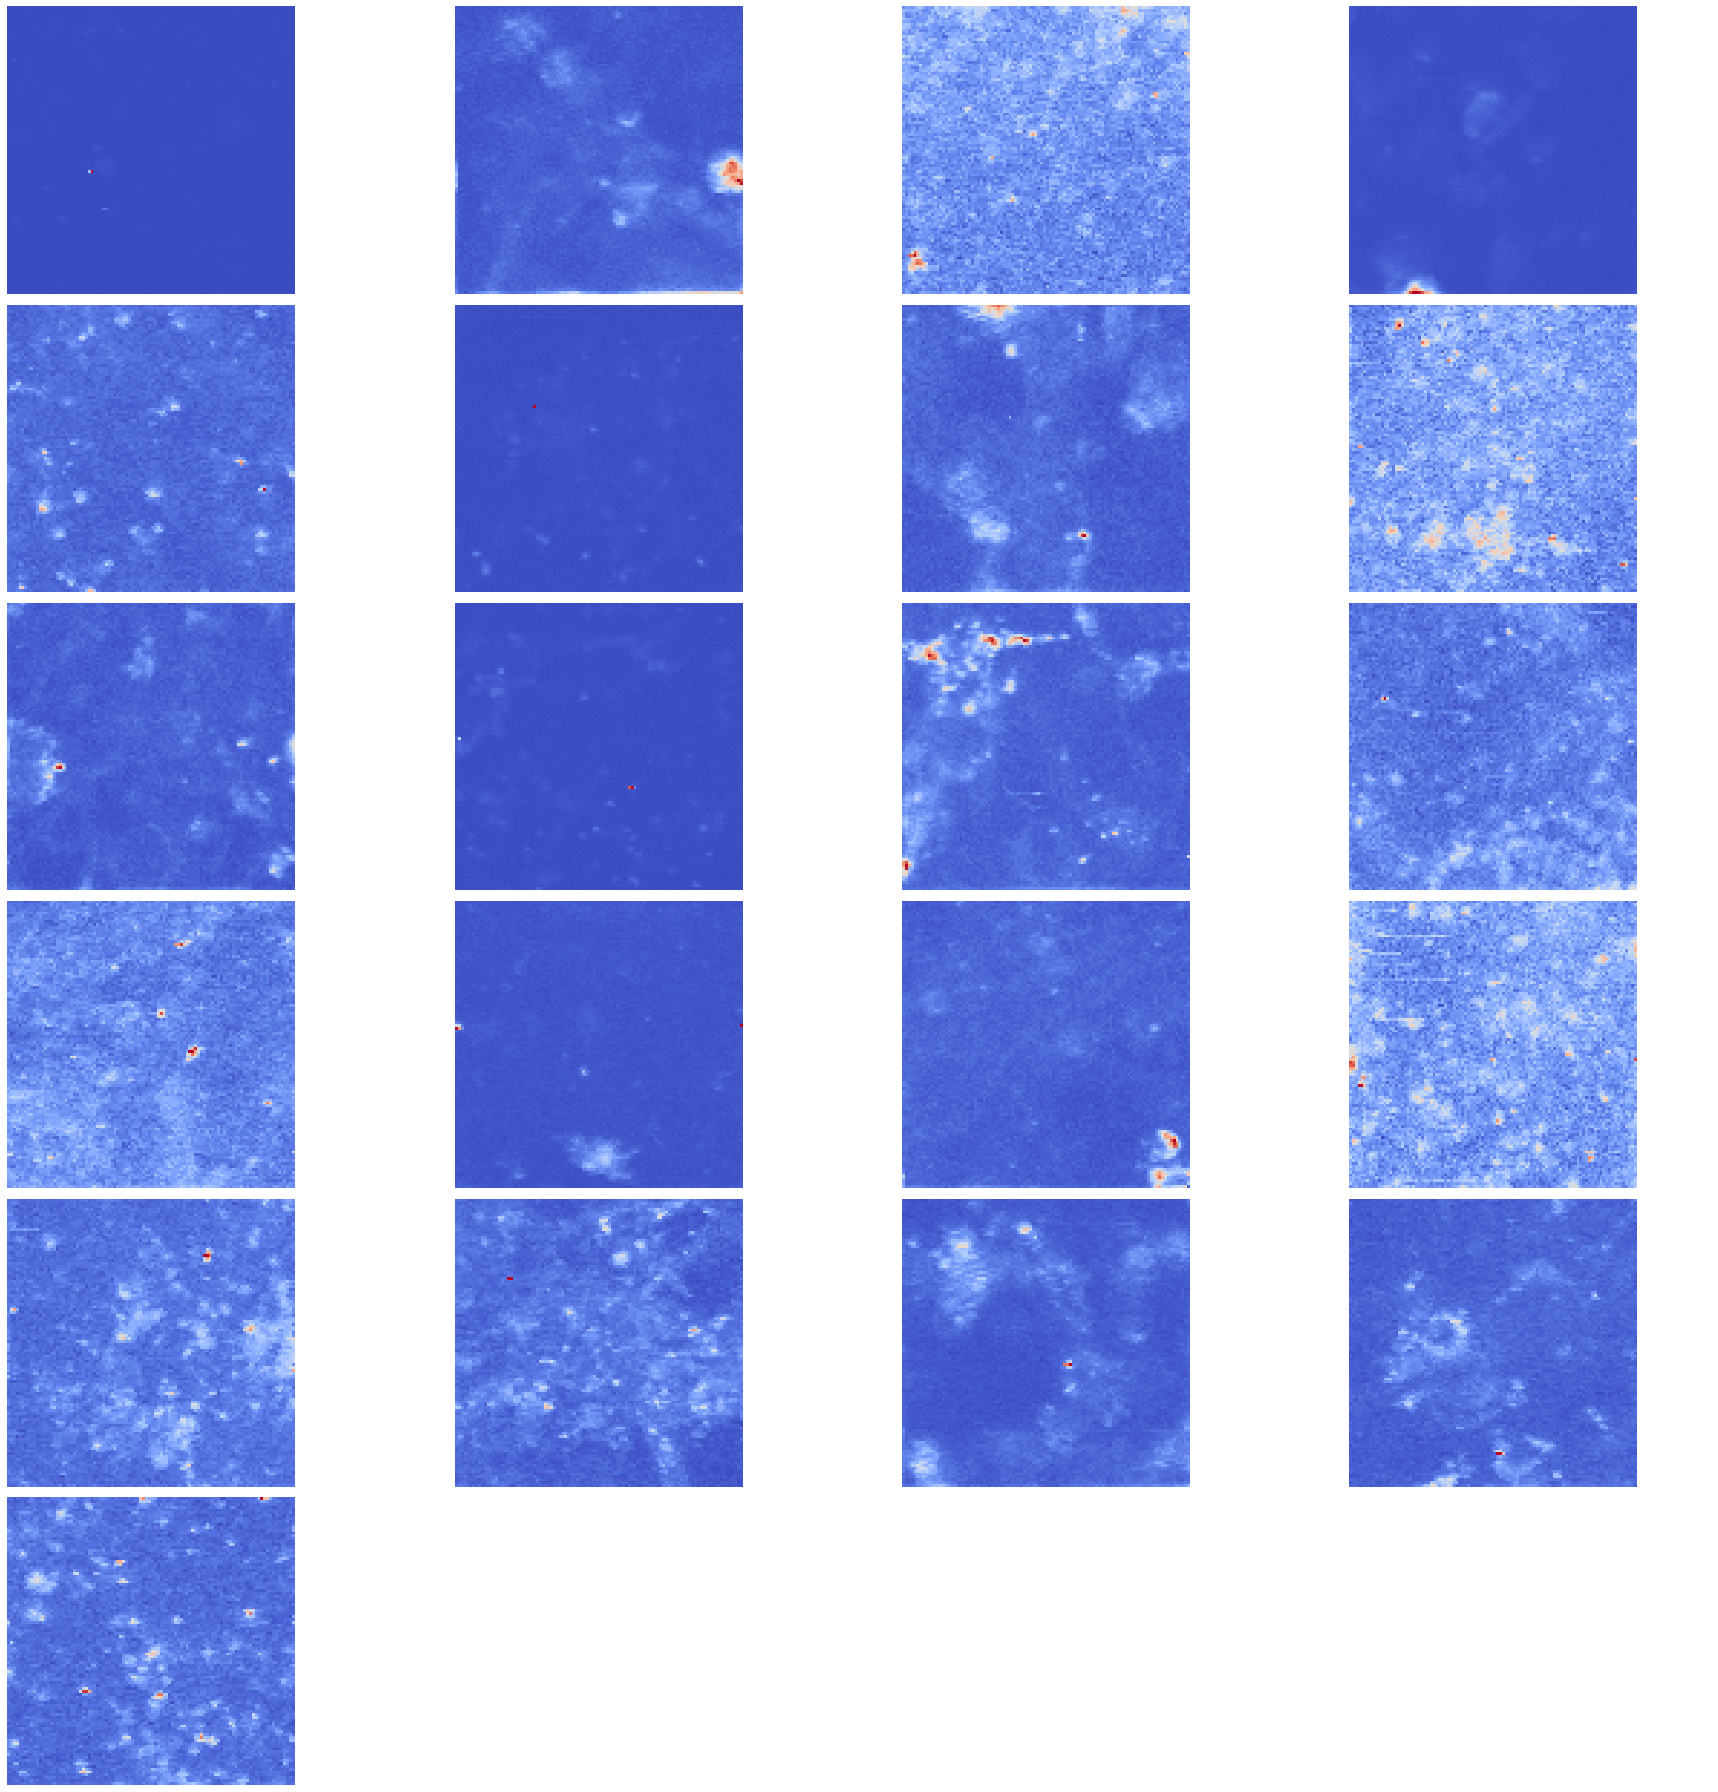

In [61]:
fig, ax = plt.subplots(6,4, figsize=(25,25))
for i, (a,img) in enumerate(zip(ax.flat,raman_669_rot)):
    a.imshow(img,cmap = 'coolwarm')
    [a.axis('off') for a in ax.flat]
plt.tight_layout();

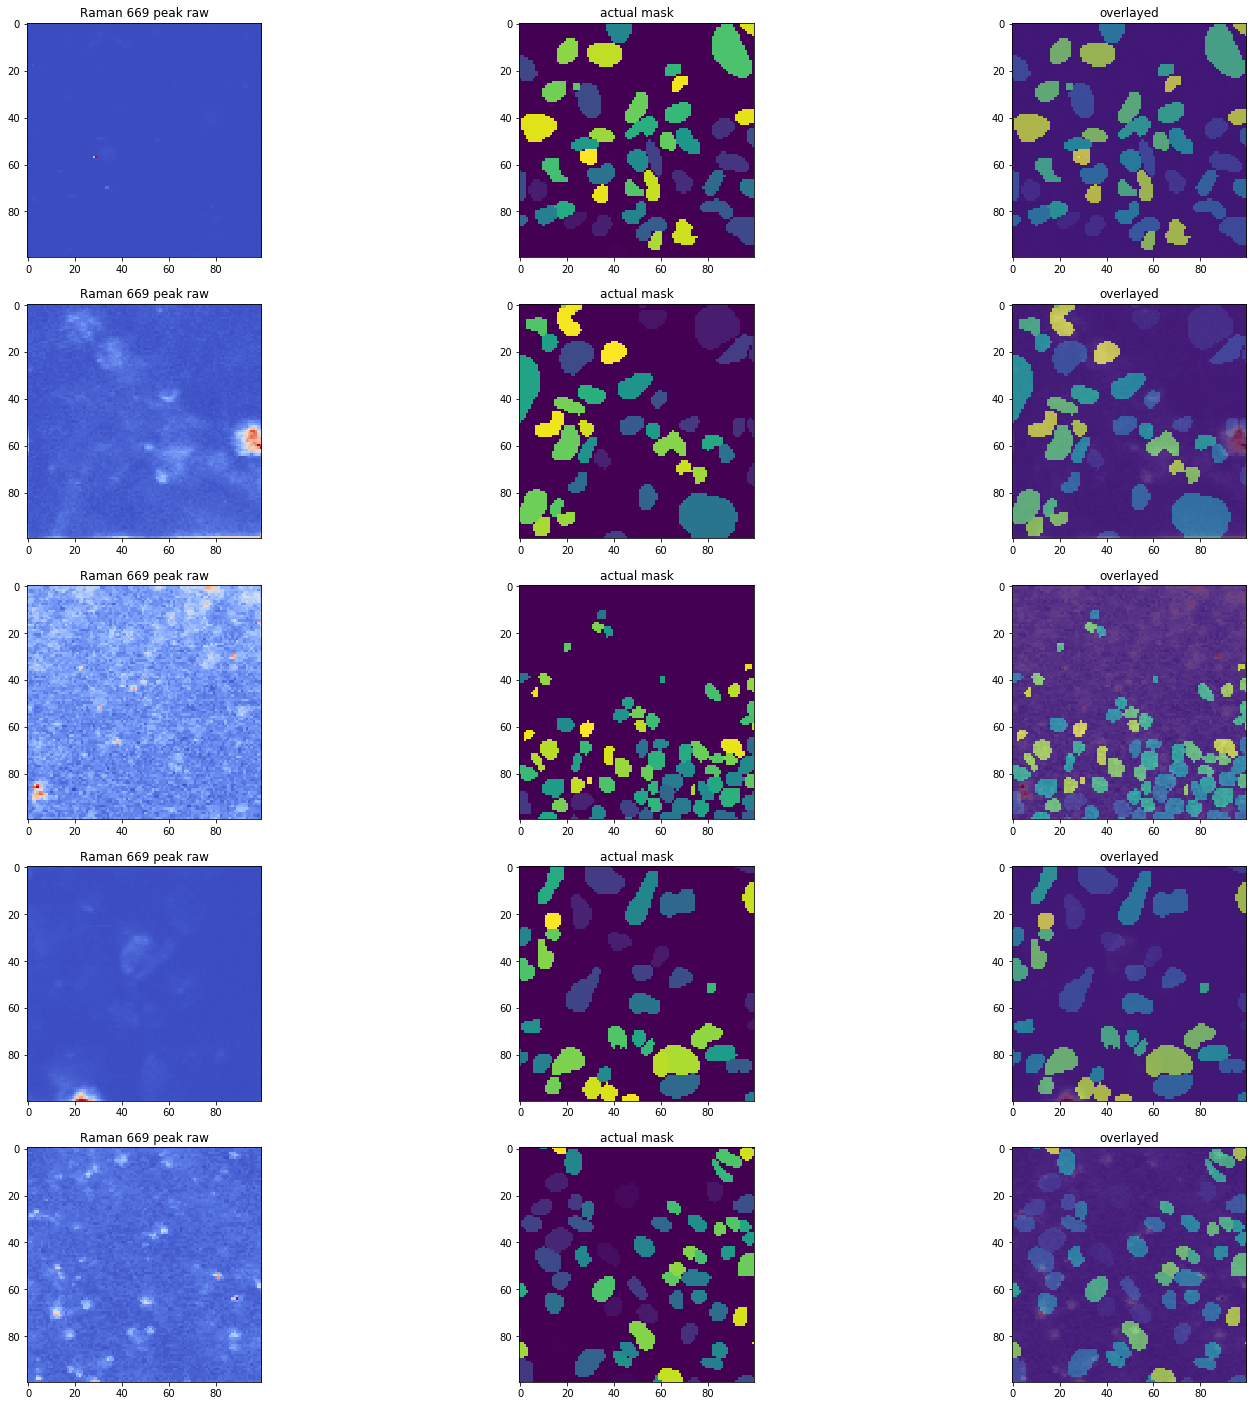

In [62]:
'''Plot upsampled mask, segmented image, created mask overlayed on cropped segmented mask and '''
fig, axs = plt.subplots(5,3, figsize=(25,25))
for i in range(5):
    axs[i][0].imshow(raman_669_rot[i],cmap='coolwarm')
    axs[i][0].set_title('Raman 669 peak raw')
    axs[i][1].imshow(small_masks[i])
    axs[i][1].set_title('actual mask')
    axs[i][2].imshow(raman_669_rot[i],cmap='coolwarm')
    axs[i][2].imshow(small_masks[i],alpha=0.7)
    axs[i][2].set_title('overlayed')

In [66]:
'''Normalize raman specs'''
raman_norm = []
for ram in raman_669_rot:
    mins = np.min(ram)
    maxs = np.max(ram)
    raman_n = (ram - mins)/(maxs-mins)
    raman_norm.append(raman_n)

In [68]:
raman_norm[0]

array([[0.00132802, 0.00442674, 0.00265604, ..., 0.00265604, 0.00177069,
        0.00221337],
       [0.00265604, 0.00221337, 0.00265604, ..., 0.00309872, 0.00265604,
        0.00265604],
       [0.00221337, 0.00265604, 0.00309872, ..., 0.00221337, 0.00177069,
        0.00265604],
       ...,
       [0.00265604, 0.00221337, 0.00177069, ..., 0.00354139, 0.00265604,
        0.00265604],
       [0.00221337, 0.00309872, 0.00309872, ..., 0.00309872, 0.00265604,
        0.00309872],
       [0.00265604, 0.00354139, 0.00398406, ..., 0.00265604, 0.00265604,
        0.00354139]])

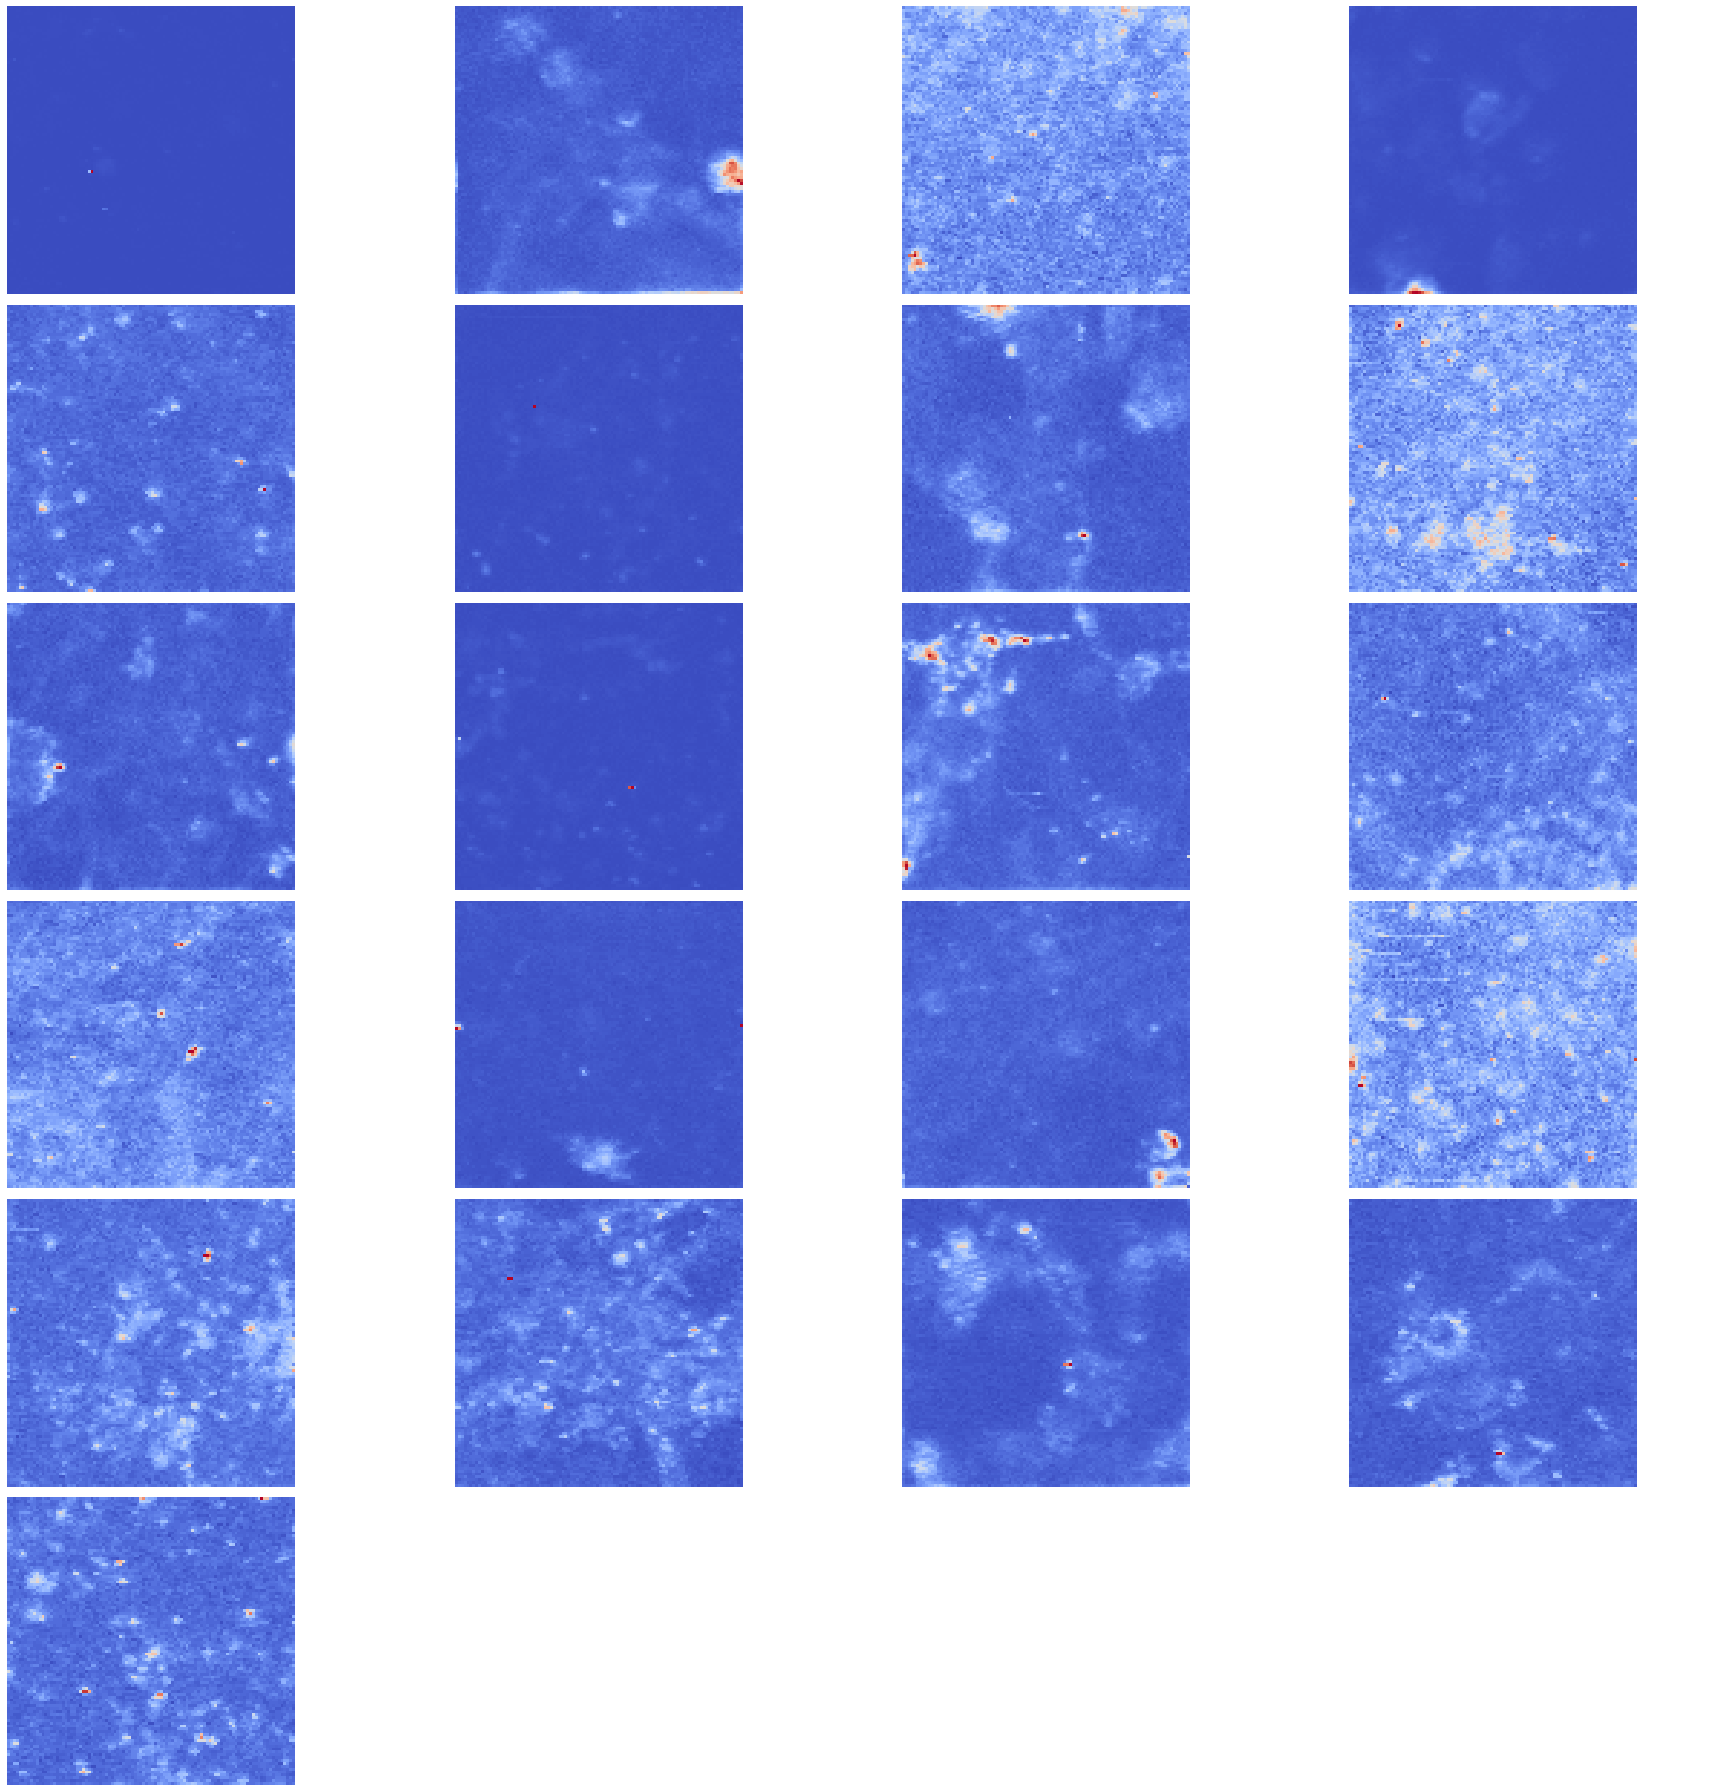

In [70]:
fig, ax = plt.subplots(6,4, figsize=(25,25))
for i, (a,img) in enumerate(zip(ax.flat,raman_norm)):
    a.imshow(img,cmap = 'coolwarm')
    [a.axis('off') for a in ax.flat]
plt.tight_layout();

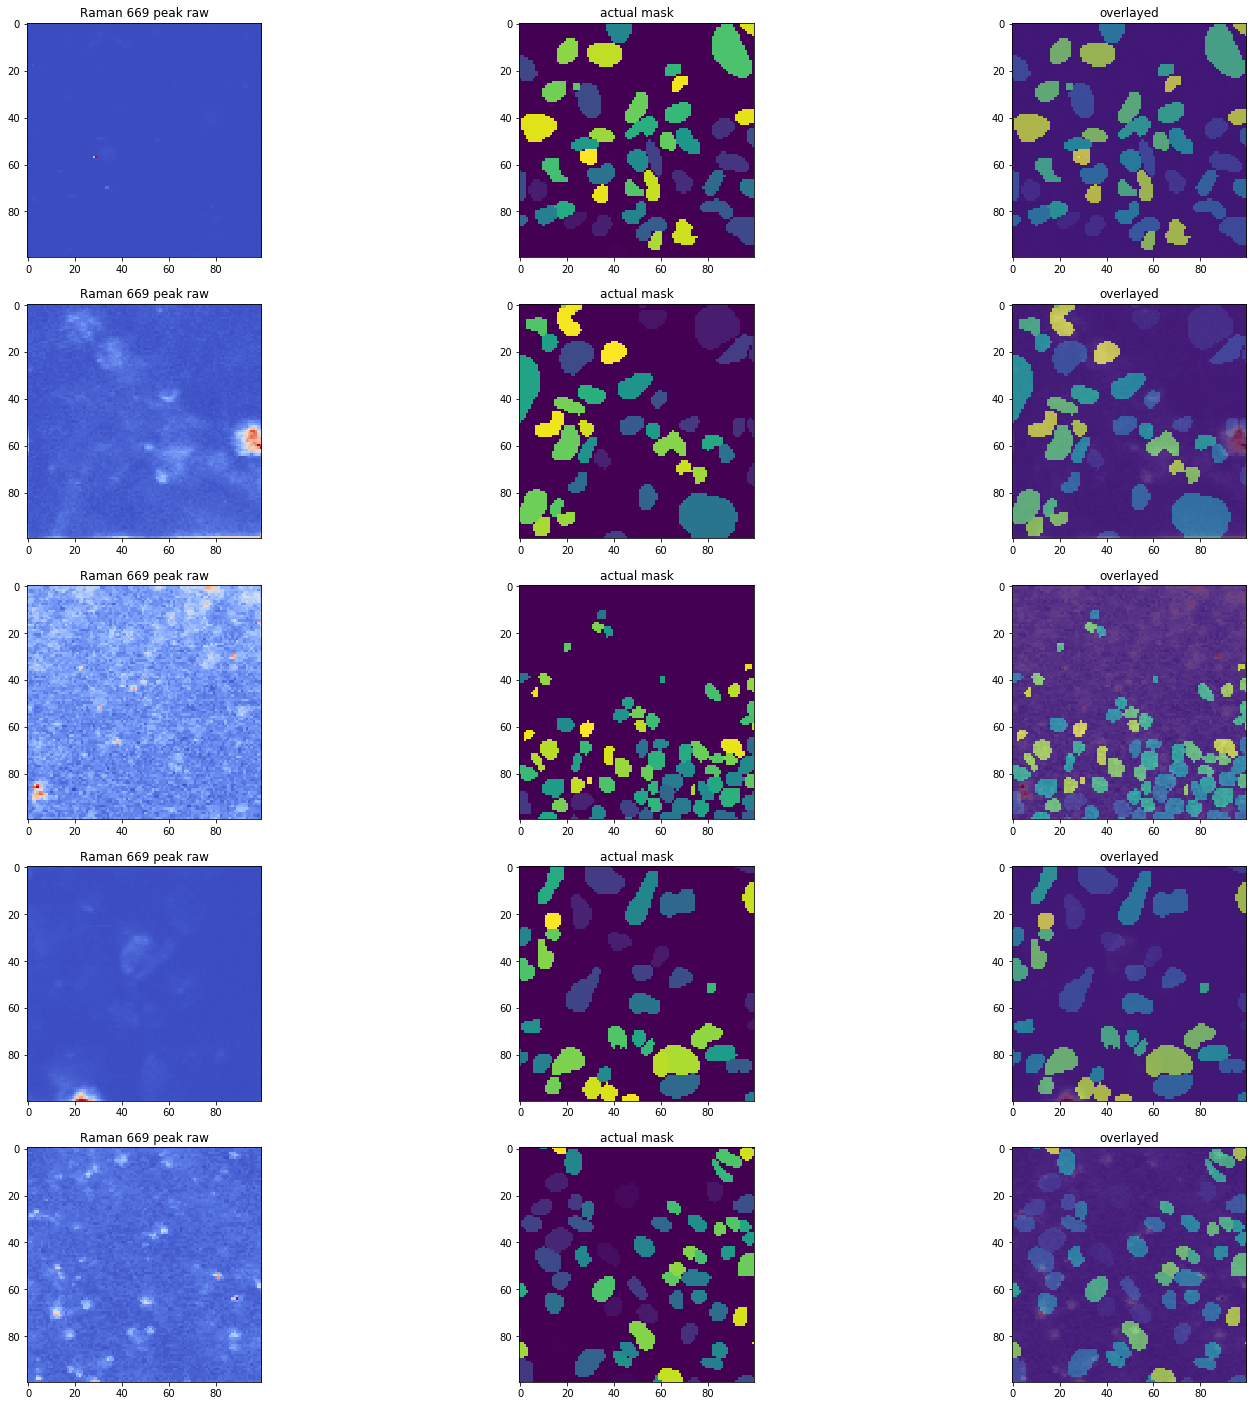

In [71]:
'''Plot upsampled mask, segmented image, created mask overlayed on cropped segmented mask and '''
fig, axs = plt.subplots(5,3, figsize=(25,25))
for i in range(5):
    axs[i][0].imshow(raman_norm[i],cmap='coolwarm')
    axs[i][0].set_title('Raman 669 peak raw')
    axs[i][1].imshow(small_masks[i])
    axs[i][1].set_title('actual mask')
    axs[i][2].imshow(raman_norm[i],cmap='coolwarm')
    axs[i][2].imshow(small_masks[i],alpha=0.7)
    axs[i][2].set_title('overlayed')

In [72]:
raman_norm[0]

array([[0.00132802, 0.00442674, 0.00265604, ..., 0.00265604, 0.00177069,
        0.00221337],
       [0.00265604, 0.00221337, 0.00265604, ..., 0.00309872, 0.00265604,
        0.00265604],
       [0.00221337, 0.00265604, 0.00309872, ..., 0.00221337, 0.00177069,
        0.00265604],
       ...,
       [0.00265604, 0.00221337, 0.00177069, ..., 0.00354139, 0.00265604,
        0.00265604],
       [0.00221337, 0.00309872, 0.00309872, ..., 0.00309872, 0.00265604,
        0.00309872],
       [0.00265604, 0.00354139, 0.00398406, ..., 0.00265604, 0.00265604,
        0.00354139]])

In [ ]:
# print()